In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib

In [10]:
from rasterio.plot import show
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

In [6]:
streets_gdf = gpd.read_file("./../pylusat/datasets/streets/streets.shp")

In [7]:
from pylusat.utils import rasterize_geometry
streets_arr = rasterize_geometry(streets_gdf, 20)

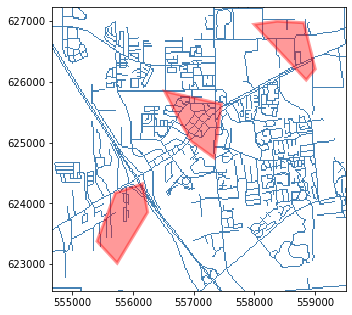

In [189]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
ax.set_aspect('equal')

left, right, bottom, top = 554676, 559500, 622563, 627232

ax.set_xlim(left, right)
ax.set_ylim(bottom, top)

levels = [0, 1, 2]
colors = ['white', 'steelblue']
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)

polygon_list = []
for i in range(3):
#     point_list = []
    for j in range(4):

#         x = left + np.random.randint(0, (j+1)*10)*100
#         y = bottom + np.random.randint(0, (j+1)*10)*100
        arr = np.array(to_convex_contour(5, i+j+26))
        arr[:,0] = arr[:,0]*1500 + i*1500 + left + 100*j
        arr[:,1] = arr[:,1]*1500 + i*1500 + bottom + 100*j
    polygon = Polygon(arr, edgecolor="red", facecolor="red", 
                      linewidth=3, alpha=0.4)
    ax.add_patch(polygon)

show(streets_arr[0], cmap=cmap, ax=ax, transform=streets_arr[1])

plt.tight_layout()

fig.savefig("./line_density.png", dpi=450)

In [131]:
import random
from math import atan2


def to_convex_contour(vertices_count, seed=5,
                      x_generator=random.random,
                      y_generator=random.random):
    """
    Port of Valtr algorithm by Sander Verdonschot.

    Reference:
        http://cglab.ca/~sander/misc/ConvexGeneration/ValtrAlgorithm.java

    >>> contour = to_convex_contour(20)
    >>> len(contour) == 20
    True
    """
    random.seed(seed)
    xs = [x_generator() for _ in range(vertices_count)]
    ys = [y_generator() for _ in range(vertices_count)]
    xs = sorted(xs)
    ys = sorted(ys)
    min_x, *xs, max_x = xs
    min_y, *ys, max_y = ys
    vectors_xs = _to_vectors_coordinates(xs, min_x, max_x)
    vectors_ys = _to_vectors_coordinates(ys, min_y, max_y)
    random.shuffle(vectors_ys)

    def to_vector_angle(vector):
        x, y = vector
        return atan2(y, x)

    vectors = sorted(zip(vectors_xs, vectors_ys),
                     key=to_vector_angle)
    point_x = point_y = 0
    min_polygon_x = min_polygon_y = 0
    points = []
    for vector_x, vector_y in vectors:
        points.append((point_x, point_y))
        point_x += vector_x
        point_y += vector_y
        min_polygon_x = min(min_polygon_x, point_x)
        min_polygon_y = min(min_polygon_y, point_y)
    shift_x, shift_y = min_x - min_polygon_x, min_y - min_polygon_y
    return [(point_x + shift_x, point_y + shift_y)
            for point_x, point_y in points]


def _to_vectors_coordinates(coordinates, min_coordinate, max_coordinate):
    last_min = last_max = min_coordinate
    result = []
    for coordinate in coordinates:
        if _to_random_boolean():
            result.append(coordinate - last_min)
            last_min = coordinate
        else:
            result.append(last_max - coordinate)
            last_max = coordinate
    result.extend((max_coordinate - last_min,
                   last_max - max_coordinate))
    return result


def _to_random_boolean():
    return random.getrandbits(1)